### PID: ejercicios

Vamos a suponer que como punto de partida ya sabemos más o menos lo que es un [PID](https://en.wikipedia.org/wiki/PID_controller).

Vamos a usar la siguiente parametrización de los coeficientes:

$$
u(t) = K_p e(t) + K_i \int_0^t e(x)\,dx + K_d\frac{d}{dt}e(t)
$$

Nuestro problema es escribir un PID para controlar el nivel de un tanque de un cliente; el cliente tiene sus loops de control implementados en python y nos ha proporcionado un simulador de su sistema para ayudarnos a desarrollar nuestro PID.

![diagram](diagram.png)

El tanque es un cilindro.

Controlamos una válvula en la tubería de entrada.

La variable de proceso que queremos controlar es el nivel del tanque en metros, $level(t)$. Nuestra señal de control $u(t)$ será truncada a un valor entre 0 y 1 que representa la apertura de la válvula de entrada.

Las dimensiones del sistema:


In [1]:
import sim

for k, v in sorted(sim.SPECS.items()):
    print(f'{k}: {v}')

CYLINDER_RADIUS_METRES: 2.0
DEMAND_BASELINE_RATE_M3_S: 0.5
IN_MAX_FLOW_RATE_M3_S: 5.0
IN_PIPE_RADIUS_METRES: 0.2
MAX_LEVEL_METRES: 7.0
MIN_LEVEL_METRES: 0.0
OUT_MAX_FLOW_RATE_M3_S: 80.0
OUT_PIPE_RADIUS_METRES: 1.0


Usan python: cuando el operario pulsa el botón de control PID el bucle de control del sistema inicializa el controlador y lo llama en bucle hasta que vuelve a control manual:

```
controller.initialize_controller(v, dt)
while control_is_on:
    setpoint = get_setpoint()
    v = get_level()
    
    controller.change_setpoint(setpoint)
    output = controller.get_output(v)
    output_between_0_1 = clip(0, 1, output)
    in_valve.set(output_between_0_1)
```

El cliente nos ha proporcionado también código para el controlador que usan actualmente, se ha basado en el [pseudocódigo sencillo de wikipedia](https://en.wikipedia.org/wiki/PID_controller#Pseudocode):

In [2]:
class Controller:
    def __init__(self, kp, ki, kd):
        self.kp = kp
        self.ki = ki
        self.kd = kd

        self.dt = None
        self.setpoint = None
        self.integrated_error = None
        self.previous_error = None

    def initialize_controller(self, v, dt):
        self.dt = dt
        self.integral = 0
        self.previous_error = 0

    def change_setpoint(self, setpoint):
        self.setpoint = setpoint

    def get_output(self, v):
        dt = self.dt

        error = self.setpoint - v
        proportional = error
        self.integral = self.integral + error * dt
        derivative = (error - self.previous_error) / dt

        output = self.kp * error + self.ki * self.integral + self.kd * derivative

        self.previous_error = error
        return output

El resultado de aplicar su controlador a la simulación de operación normal coincide con lo que observan empíricamente.

In [3]:
controller = Controller(2.0, 0.5, 0.0)
df, events = sim.simulate_normal(controller)
df

,time,m3,demand,setpoint,controller_output,delta_demand,in_signal,in_flow,out_flow,level
0,0.00,62.831853,0.000,0.0,0.000000,0.000,0.000000,0.000000,0.000,5.000000
1,0.01,62.831853,0.000,5.0,0.000000,0.000,0.000000,0.000000,0.000,5.000000
2,0.02,62.831853,0.005,5.0,0.000000,0.005,0.000000,0.000000,0.000,5.000000
3,0.03,62.826853,0.005,5.0,0.000000,0.005,0.000000,0.000000,0.005,4.999602
4,0.04,62.821893,0.005,5.0,0.000798,0.005,0.000798,0.000040,0.005,4.999207
...,...,...,...,...,...,...,...,...,...,...
997,9.97,64.241421,0.005,5.0,0.278189,0.005,0.278189,0.013909,0.005,5.112170
998,9.98,64.250232,0.005,5.0,0.276210,0.005,0.276210,0.013811,0.005,5.112871
999,9.99,64.258944,0.005,5.0,0.274244,0.005,0.274244,0.013712,0.005,5.113564
1000,10.00,64.267558,0.005,5.0,0.272289,0.005,0.272289,0.013614,0.005,5.114250


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='seconds', ylabel='level'>)

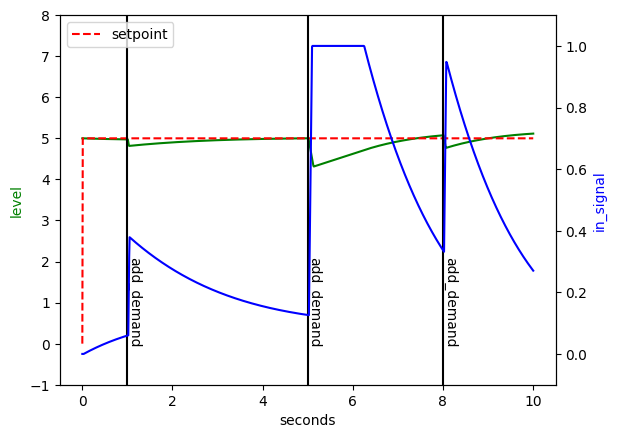

In [4]:
sim.plot_simulation(df, events)

### Ejercicio 1

El cliente ha detectado que otros sistemas downstream de la tubería de entrada estaban mal especificados y corren riesgo catastrófico de martillo hidráulico si la velocidad en la tubería supera los $120 \frac{km}{h}$.

Han medido velocidades en exceso de $140 \frac{km}{h}$ en comportamiento normal con los settings de PID actuales.

El cliente tendrá que parar la instalación a no ser que se pueda garantizar que no habrá ninguna combinación de cambios de setpoint y condiciones de demanda que puedan llevar a superar esta velocidad en la tubería de entrada. Por razones de certificación tampoco permiten cambios en el código: solo pueden llevar a cabo cambios en los coeficientes del PID.

**¿Hay alguna forma de cambiar los coeficientes de PID para garantizar esta condición?** Así la instalación podrá seguir abierta aunque con funcionamiento degradado.

No es suficiente que la velocidad se mantenga debajo del umbral en las simulaciones: el cliente necesita un argumento que demuestre que los coeficientes funcionarán para cualquier situación.

### Ejercicio 2

Los operarios han observado que cuando encienden el sistema con el tanque vacío la bomba sigue en marcha mucho tiempo después de llegar al setpoint, haciendo rebasar el nivel del tanque y malgastando agua.

Por ahora lo mitigan subiendo el setpoint a mano gradualmente cuando se dan cuenta: algunos argumentan que podrían evitar este comportamiento totalmente eliminando el coeficiente integral $K_i$ pero otros se resisten ya que han observado que cuando eliminan el coeficiente integral las bombas se rompen con más frecuencia.

**¿Puedes escribir un controlador alternativo `Controller2` modificando el `Controller` original que resuelva esto sin tener que eliminar el control integral?**

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='seconds', ylabel='level'>)

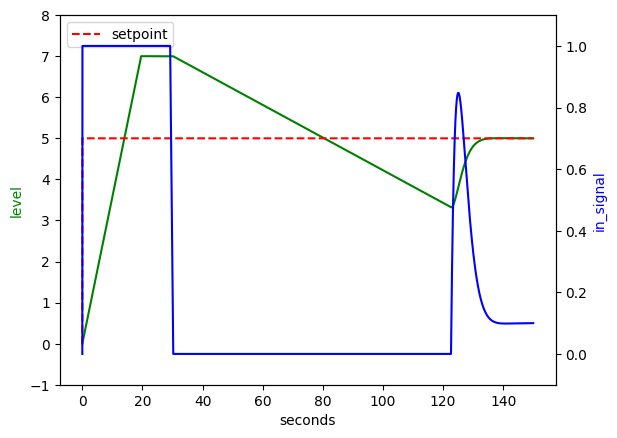

In [7]:
controller = Controller(2.0, 0.5, 0.0)
df, events = sim.simulate_strange(controller)
sim.plot_simulation(df, events)